In [40]:
PATH_FRC = "./code/"

GAUSS_L2_MODEL = './models/gaussian_l2/models/1/'
GAUSS_FRC_MODEL = './models/gaussian_frc/models/1/'
GAUSS_L1_MODEL = './models/gaussian_l1/models/1/'

LOGNORM_L2_MODEL = './models/lognorm_fig5/315/'
LOGNORM_FRC_MODEL = './models/lognorm_fig5/314/'
LOGNORM_L1_MODEL = './models/lognorm_fig5/316/'

EM_L2_MODEL = './models/em_models/343/'
EM_FRC_MODEL = './models/em_models/342/'

GOI_IMAGES = './google_data/test/*.jpg'
EM_IMAGES_EVEN = './em_data/test/*_even*.png'
EM_IMAGES_ODD = './em_data/test/*_odd*.png'

In [12]:
import os
import sys
import glob
from tqdm import tqdm

import numpy as np
import matplotlib
import pandas as pd

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import logging
tf.get_logger().setLevel(logging.ERROR)
import tensorflow as tf
import skimage
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.metrics import mean_squared_error,structural_similarity

sys.path.append(PATH_FRC)

from dataset import create_list_dataset, process_image_single, add_noise
from models2 import FRCUnetModel
from functools import partial

import tensorflow_probability as tfp

matplotlib.rcParams.update({'mathtext.default':'regular'})
matplotlib.rcParams.update({'font.size': 8})
matplotlib.rcParams.update({'axes.labelweight': 'bold'})
matplotlib.rcParams.update({'axes.titleweight': 'bold'})

In [92]:
def normalise_img(image):
    image = image - image.min()
    image = image/image.max() - 0.5
    return image

def load_data(DATA_LOCATION, resize=True):
    clean_images=[]
    for file in sorted(glob.glob(DATA_LOCATION)):
        clean = imread(file)
        if len(clean.shape) > 2:
            clean = np.mean(clean, axis=2)
        if resize:
            minsize = np.array(clean.shape).min()
            clean = clean[:minsize,:minsize]
            clean=tf.convert_to_tensor(clean)
            clean=clean[tf.newaxis, ..., tf.newaxis]
            clean=tf.image.resize(
            clean, [256,256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, \
                preserve_aspect_ratio=True, antialias=False, name=None)
            clean=clean.numpy().squeeze()
        clean = normalise_img(clean)
        clean = clean.astype('float32')
        clean_images.append(clean)
    return clean_images

def load_model(model_dir, model_fname):
    if model_dir is not None:
        return FRCUnetModel(None, model_path=os.path.join(model_dir, model_fname))

def fourier_ring_correlation_by_ring(image1, image2, rn, spatial_freq):
    # we need the channels first format for this loss
    image1 = tf.transpose(image1, perm=[0, 3, 1, 2])
    image2 = tf.transpose(image2, perm=[0, 3, 1, 2])
    image1 = tf.cast(image1, tf.complex64)
    image2 = tf.cast(image2, tf.complex64)
    rn = tf.cast(rn, tf.complex64)
    fft_image1 = tf.signal.fftshift(tf.signal.fft2d(image1), axes=[2, 3])
    fft_image2 = tf.signal.fftshift(tf.signal.fft2d(image2), axes=[2, 3])

    t1 = tf.multiply(fft_image1, rn)  # (128, BS?, 3, 256, 256)
    t2 = tf.multiply(fft_image2, rn)
    c1 = tf.math.real(tf.reduce_sum(tf.multiply(t1, tf.math.conj(t2)), [2, 3, 4]))
    c2 = tf.reduce_sum(tf.math.abs(t1) ** 2, [2, 3, 4])
    c3 = tf.reduce_sum(tf.math.abs(t2) ** 2, [2, 3, 4])
    frc = tf.math.divide(c1, tf.math.sqrt(tf.math.multiply(c2, c3)))
    frc = tf.where(tf.compat.v1.is_inf(frc), tf.zeros_like(frc), frc)  # inf
    frc = tf.where(tf.compat.v1.is_nan(frc), tf.zeros_like(frc), frc)  # nan
    
    riemann_sum = tf.reduce_sum(tf.multiply(spatial_freq[1:] - spatial_freq[:-1], (frc[:-1] + frc[1:]) / 2.), 0)
    return frc, riemann_sum.numpy()[0]
 
def get_stats(model, image, noisy_image,radial_masks, spatial_freq):
    
    denoised = model(np.reshape(noisy_image, [1,256, 256,1]))
    denoised = model.scale(denoised) - 0.5
    mse = mean_squared_error(np.squeeze(image), np.squeeze(denoised))
    ssim = structural_similarity(np.squeeze(image), np.squeeze(denoised))
    frc_by_ring, frc = fourier_ring_correlation_by_ring(np.reshape(image, [1,256, 256,1]),\
                                                np.reshape(denoised, [1,256, 256,1]), 
                                         radial_masks, spatial_freq)
    
    return denoised, mse, ssim, frc, frc_by_ring

def process_set(im_data,L2_MODEL,FRC_MODEL,L1_MODEL,model_names,\
                noise_model='lognormal', im_data_odd=None):
    results = [[],[],[]]

    for a,model_name in tqdm(enumerate(model_names[:])):
        mse_model = load_model(L2_MODEL, model_name)
        frc_model = load_model(FRC_MODEL, model_name)
        mae_model = load_model(L1_MODEL, model_name)
        if a == 0:
            radial_masks,spatial_freq = mse_model.radial_masks, mse_model.spatial_freq
        mse_stats,frc_stats,mae_stats = [],[],[]

        for idx, image in enumerate(im_data):
            if noise_model == 'lognormal':
                noise=np.random.lognormal(0,1.3,256**2).reshape(256,256) -1
                noisy_image=im_data[idx]+noise
            elif noise_model == 'normal':
                noise=np.random.normal(0,0.4,256**2).reshape(256,256)
                noisy_image=im_data[idx]+noise
            elif noise_model == None:
                noisy_image = im_data_odd[idx]
                        

            mse_stats.append(get_stats(mse_model, image, noisy_image,radial_masks,spatial_freq))
            mae_stats.append(get_stats(mae_model, image, noisy_image,radial_masks,spatial_freq))
            frc_stats.append(get_stats(frc_model, image, noisy_image,radial_masks,spatial_freq))
        
        results[0].append(mse_stats)
        results[1].append(mae_stats)
        results[2].append(frc_stats)
    return results

In [93]:
goi_test_images = load_data(GOI_IMAGES)
em_even_test_images = load_data(EM_IMAGES_EVEN,resize=False)
em_odd_test_images = load_data(EM_IMAGES_ODD,resize=False)
model_names = ['saved-model-batch-{}'.format(idx) for idx in [2 ** x for x in range(20)]]

In [94]:
#Expensive loop, mostly because of slow model loading, and we load here hundreds of models
gaussian_noise = process_set(goi_test_images,GAUSS_L2_MODEL,GAUSS_FRC_MODEL,GAUSS_L1_MODEL,model_names,\
                noise_model='normal')

20it [20:02, 60.15s/it]


In [95]:
#Expensive loop
lognormal_noise = process_set(goi_test_images,LOGNORM_L2_MODEL,LOGNORM_FRC_MODEL,LOGNORM_L1_MODEL,model_names,\
                noise_model='lognormal')

20it [19:41, 59.06s/it]


In [ ]:
#Expensive loop
em_noise = process_set(em_even_test_images[:200],EM_L2_MODEL,EM_FRC_MODEL,EM_L2_MODEL,model_names,\
                None,em_odd_test_images[:200]) #the second em_l2_model is empty calculation


17it [1:00:10, 215.93s/it]

In [104]:
average_gaussian_noise = np.array(gaussian_noise,dtype=object)
average_gaussian_noise = average_gaussian_noise[:,:,:,1:-1] #first is denoised image
average_gaussian_noise = average_gaussian_noise.mean(axis=2)

average_lognormal_noise = np.array(lognormal_noise,dtype=object)
average_lognormal_noise = average_lognormal_noise[:,:,:,1:-1]
average_lognormal_noise = average_lognormal_noise.mean(axis=2)

average_em_noise = np.array(em_noise,dtype=object)
average_em_noise = average_em_noise[:,:,:,1:-1]
average_em_noise = average_em_noise.mean(axis=2)

In [107]:
data=pd.DataFrame(2**np.arange(20))
data.columns=['gaussian-x']

### Normal noise
data['gaussian-l2-mse']=average_gaussian_noise[0].T[0]
data['gaussian-l2-ssim']=average_gaussian_noise[0].T[1]
data['gaussian-l2-frc']=average_gaussian_noise[0].T[2]

data['gaussian-l1-mse']=average_gaussian_noise[1].T[0]
data['gaussian-l1-ssim']=average_gaussian_noise[1].T[1]
data['gaussian-l1-frc']=average_gaussian_noise[1].T[2]

data['gaussian-frc-mse']=average_gaussian_noise[2].T[0]
data['gaussian-frc-ssim']=average_gaussian_noise[2].T[1]
data['gaussian-frc-frc']=average_gaussian_noise[2].T[2]

### Lognormal noise
data['lognormal-l2-mse']=average_lognormal_noise[0].T[0]
data['lognormal-l2-ssim']=average_lognormal_noise[0].T[1]
data['lognormal-l2-frc']=average_lognormal_noise[0].T[2]

data['lognormal-l1-mse']=average_lognormal_noise[1].T[0]
data['lognormal-l1-ssim']=average_lognormal_noise[1].T[1]
data['lognormal-l1-frc']=average_lognormal_noise[1].T[2]

data['lognormal-frc-mse']=average_lognormal_noise[2].T[0]
data['lognormal-frc-ssim']=average_lognormal_noise[2].T[1]
data['lognormal-frc-frc']=average_lognormal_noise[2].T[2]

### EM data set
data['em-l2-mse']=average_em_noise[0].T[0]
data['em-l2-ssim']=average_em_noise[0].T[1]
data['em-l2-frc']=average_em_noise[0].T[2]

data['em-frc-mse']=average_em_noise[2].T[0]
data['em-frc-ssim']=average_em_noise[2].T[1]
data['em-frc-frc']=average_em_noise[2].T[2]

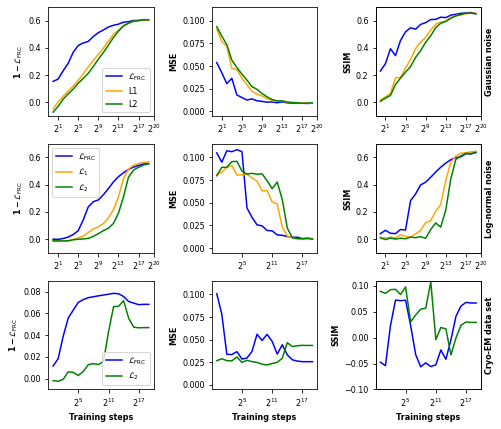

In [108]:
fig = plt.figure()
fig.set_size_inches(7, 6)
xticks_positions=[2,32,512,8192,131072,1048576]

ax = fig.add_subplot(331)
ax.plot(data['gaussian-x'],data['gaussian-frc-frc'] , label=r'$\mathcal{L}_{\mathrm{FRC}}$', lw=1.5, c='blue')
ax.plot(data['gaussian-x'],data['gaussian-l1-frc'] , label='L1', lw=1.5, c='orange')
ax.plot(data['gaussian-x'],data['gaussian-l2-frc'] , label='L2', lw=1.5, c='green')
plt.locator_params(axis='y', nbins=5)
plt.ylabel(r'$1-\mathcal{L}_{\mathrm{FRC}}$')
plt.ylim([-0.1,0.7])
ax.legend(loc=4)
ax.set_xscale('log', base=2)
ax.set_xticks(xticks_positions)

ax = fig.add_subplot(332)
ax.plot(data['gaussian-x'],data['gaussian-frc-mse'] , label=r'$\mathcal{L}_{\mathrm{FRC}}$', lw=1.5, c='blue')
ax.plot(data['gaussian-x'],data['gaussian-l1-mse'] , label=r'$\mathcal{L}_1$', lw=1.5, c='orange')
ax.plot(data['gaussian-x'],data['gaussian-l2-mse'] , label=r'$\mathcal{L}_2$', lw=1.5, c='green')
plt.locator_params(axis='y', nbins=5)
plt.ylabel('MSE')
plt.ylim([-0.005,0.115])
ax.set_xscale('log', base=2)
ax.set_xticks(xticks_positions)

ax = fig.add_subplot(333)
ax.plot(data['gaussian-x'],data['gaussian-frc-ssim'] , label=r'$\mathcal{L}_{\mathrm{FRC}}$', lw=1.5, c='blue')
ax.plot(data['gaussian-x'],data['gaussian-l1-ssim'] , label=r'$\mathcal{L}_1$', lw=1.5, c='orange')
ax.plot(data['gaussian-x'],data['gaussian-l2-ssim'] , label='L2', lw=1.5, c='green')
plt.locator_params(axis='y', nbins=5)
plt.ylabel('SSIM')
plt.ylim([-0.1,0.7])
ax.set_xscale('log', base=2)
ax.set_xticks(xticks_positions)
ax2 = ax.twinx()
ax2.set_ylabel('Gaussian noise')
ax2.set_yticks([])

ax = fig.add_subplot(334)
ax.plot(data['gaussian-x'],data['lognormal-frc-frc'] , label=r'$\mathcal{L}_{\mathrm{FRC}}$', lw=1.5, c='blue')
ax.plot(data['gaussian-x'],data['lognormal-l1-frc'] , label=r'$\mathcal{L}_1$', lw=1.5, c='orange')
ax.plot(data['gaussian-x'],data['lognormal-l2-frc'] , label=r'$\mathcal{L}_2$', lw=1.5, c='green')
plt.locator_params(axis='y', nbins=5)
plt.ylabel(r'$1-\mathcal{L}_{\mathrm{FRC}}$')
plt.ylim([-0.1,0.7])
ax.legend(loc=2)
ax.set_xscale('log', base=2)
ax.set_xticks(xticks_positions)

ax = fig.add_subplot(335)
ax.plot(data['gaussian-x'],data['lognormal-frc-mse'] , label=r'$\mathcal{L}_{\mathrm{FRC}}$', lw=1.5, c='blue')
ax.plot(data['gaussian-x'],data['lognormal-l1-mse'] , label=r'$\mathcal{L}_1$', lw=1.5, c='orange')
ax.plot(data['gaussian-x'],data['lognormal-l2-mse'] , label=r'$\mathcal{L}_2$', lw=1.5, c='green')
plt.locator_params(axis='y', nbins=5)
ax.set_xticks(xticks_positions)
plt.ylabel('MSE')
plt.ylim([-0.005,0.115])
ax.set_xscale('log', base=2)

ax = fig.add_subplot(336)
ax.plot(data['gaussian-x'],data['lognormal-frc-ssim'] , label=r'$\mathcal{L}_{\mathrm{FRC}}$', lw=1.5, c='blue')
ax.plot(data['gaussian-x'],data['lognormal-l1-ssim'] , label=r'$\mathcal{L}_1$', lw=1.5, c='orange')
ax.plot(data['gaussian-x'],data['lognormal-l2-ssim'] , label=r'$\mathcal{L}_2$', lw=1.5, c='green')
plt.locator_params(axis='y', nbins=5)
plt.ylabel('SSIM')
plt.ylim([-0.1,0.7])
ax.set_xscale('log', base=2)
ax.set_xticks(xticks_positions)
ax2 = ax.twinx()
ax2.set_ylabel('Log-normal noise')
ax2.set_yticks([])

ax = fig.add_subplot(337)
ax.plot(data['gaussian-x'],data['em-frc-frc'] , label=r'$\mathcal{L}_{\mathrm{FRC}}$', lw=1.5, c='blue')
ax.plot(data['gaussian-x'],data['em-l2-frc'] , label=r'$\mathcal{L}_2$', lw=1.5, c='green')
plt.locator_params(axis='y', nbins=5)
plt.ylabel(r'$1-\mathcal{L}_{\mathrm{FRC}}$')
plt.ylim([-0.01,0.09])
ax.legend(loc=4)
ax.set_xticks(xticks_positions)
ax.set_xlabel('Training steps')
ax.set_xscale('log', base=2)

ax = fig.add_subplot(338)
ax.plot(data['gaussian-x'],data['em-frc-mse'] , label=r'$\mathcal{L}_{\mathrm{FRC}}$', lw=1.5, c='blue')
ax.plot(data['gaussian-x'],data['em-l2-mse'] , label=r'$\mathcal{L}_2$', lw=1.5, c='green')
plt.locator_params(axis='y', nbins=5)
plt.ylabel('MSE')
plt.ylim([-0.005,0.115])
ax.set_xticks(xticks_positions)
ax.set_xlabel('Training steps')
ax.set_xscale('log', base=2)

ax = fig.add_subplot(339)
ax.plot(data['gaussian-x'],data['em-frc-ssim'] , label=r'$\mathcal{L}_{\mathrm{FRC}}$', lw=1.5, c='blue')
ax.plot(data['gaussian-x'],data['em-l2-ssim'] , label=r'$\mathcal{L}_2$', lw=1.5, c='green')
plt.locator_params(axis='y', nbins=5)
plt.ylabel('SSIM')
plt.ylim([-0.1,0.11])
ax.set_xticks(xticks_positions)
ax.set_xscale('log', base=2)
ax.set_xlabel('Training steps')
ax2 = ax.twinx()
ax2.set_ylabel('Cryo-EM data set')
ax2.set_yticks([])

fig.tight_layout()
fig.savefig('figure_4.png', dpi=300)